In [1]:
import h5py
import numpy as np
import pandas as pd
import os
import imageio

In [2]:
h5_dir = r'\\xrm\Files\AppsDemo2\X-ray_Systems\LSU'
f = h5py.File(os.path.join(h5_dir,'LSU_DCT.h5'), 'r')

In [3]:
list(f.keys())

['AbsorptionCT', 'Date', 'LabDCT', 'PhaseInfo', 'ProjectInfo', 'Version']

In [4]:
list(f['LabDCT'].keys())

['Center', 'Data', 'Extend', 'Spacing', 'VirtualShift']

In [5]:
DCT_data = f['LabDCT']['Data']

In [6]:
list(DCT_data.keys())

['Completeness', 'GrainId', 'IPF001', 'PhaseId', 'Rodrigues']

In [7]:
DCT_grains = DCT_data['GrainId'][()] #get values from HDF5

In [8]:
print(DCT_grains.max())
print(DCT_grains.min())
print(DCT_grains.shape)

1225
0
(116, 135, 135)


In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [10]:
def get_grain_location(data, grain_id):
    locations = np.asarray(np.where(data == grain_id))
    
    return locations

In [11]:
grain = get_grain_location(DCT_grains, 599)

In [12]:
grain

array([[ 38,  38,  38, ..., 111, 111, 111],
       [ 91,  93,  96, ...,  90,  90,  91],
       [ 95,  96, 103, ...,  80,  81,  80]], dtype=int64)

In [13]:
blank_im = np.zeros_like(DCT_grains)

In [14]:
blank_im[tuple(grain)] = 255

<IPython.core.display.Javascript object>


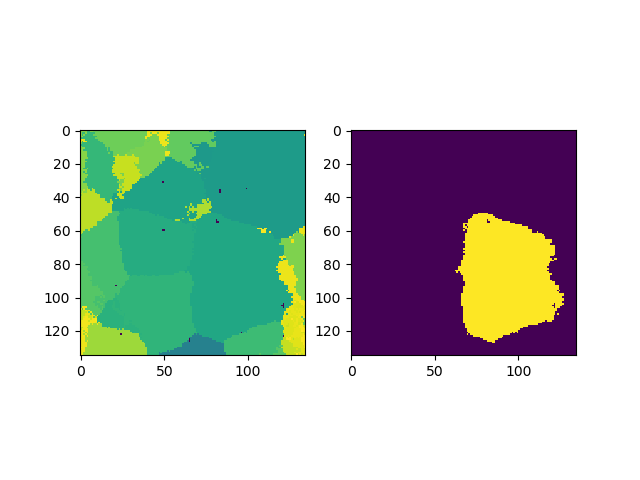

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(DCT_grains[76,:,:])
ax[1].imshow(blank_im[76,:,:])

plt.show()

In [17]:
DCT_colours = DCT_data['IPF001'][()] #get values from HDF5

In [18]:
DCT_colours.shape

(116, 135, 135, 3)

In [19]:
DCT_colours[tuple(grain)].mean(axis=0)

array([0.30110422, 0.9847462 , 1.        ], dtype=float32)

In [ ]:
# Make sure grain is single colour value. Fill grain with average colour

In [23]:
DCT_avg_colours = np.zeros_like(DCT_colours)
for grain_id in range(DCT_grains.max()+1):
    grain = get_grain_location(DCT_grains, grain_id)
    avg_colour = DCT_colours[tuple(grain)].mean(axis=0)
    DCT_avg_colours[tuple(grain)] = avg_colour

<IPython.core.display.Javascript object>


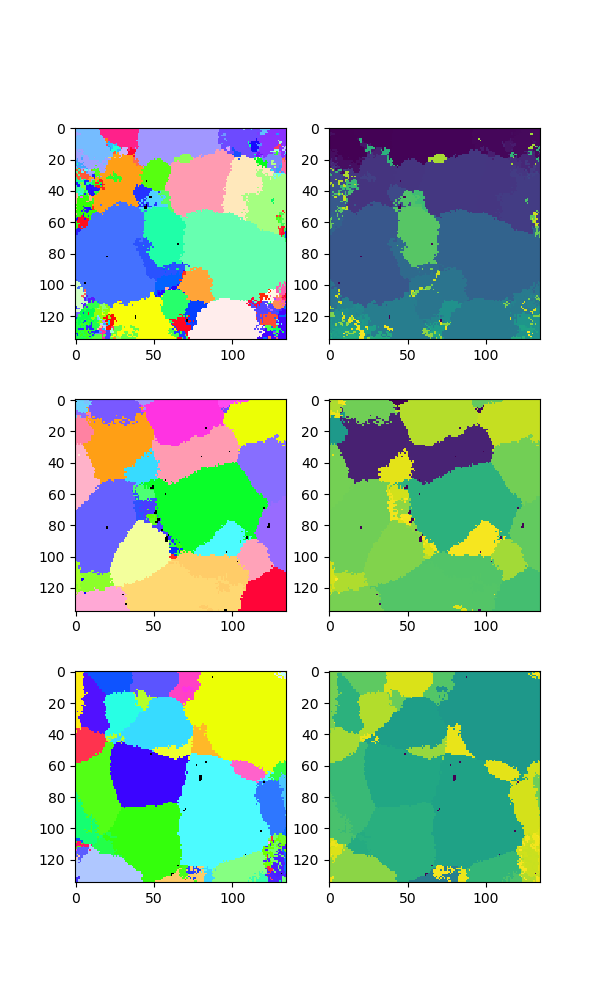

In [24]:
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(6, 10))
ax[0,0].imshow(DCT_avg_colours[2,:,:])
ax[1,0].imshow(DCT_avg_colours[40,:,:])
ax[2,0].imshow(DCT_avg_colours[80,:,:])
ax[0,1].imshow(DCT_grains[2,:,:])
ax[1,1].imshow(DCT_grains[40,:,:])
ax[2,1].imshow(DCT_grains[80,:,:])
plt.show()

In [25]:
from scipy import ndimage

In [ ]:
# Apply median filter to grain id, use this boundary as what to fill colours 

In [26]:
DCT_grains_med = ndimage.median_filter(DCT_grains, 7)

In [27]:
DCT_avg_colours_med = np.zeros_like(DCT_colours)
for grain_id in range(DCT_grains_med.max()+1):
    grain = get_grain_location(DCT_grains_med, grain_id)
    avg_colour = DCT_colours[tuple(grain)].mean(axis=0)
    DCT_avg_colours_med[tuple(grain)] = avg_colour

C:\Users\ZEISS\Miniconda3\envs\ColorIndex\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\Users\ZEISS\Miniconda3\envs\ColorIndex\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


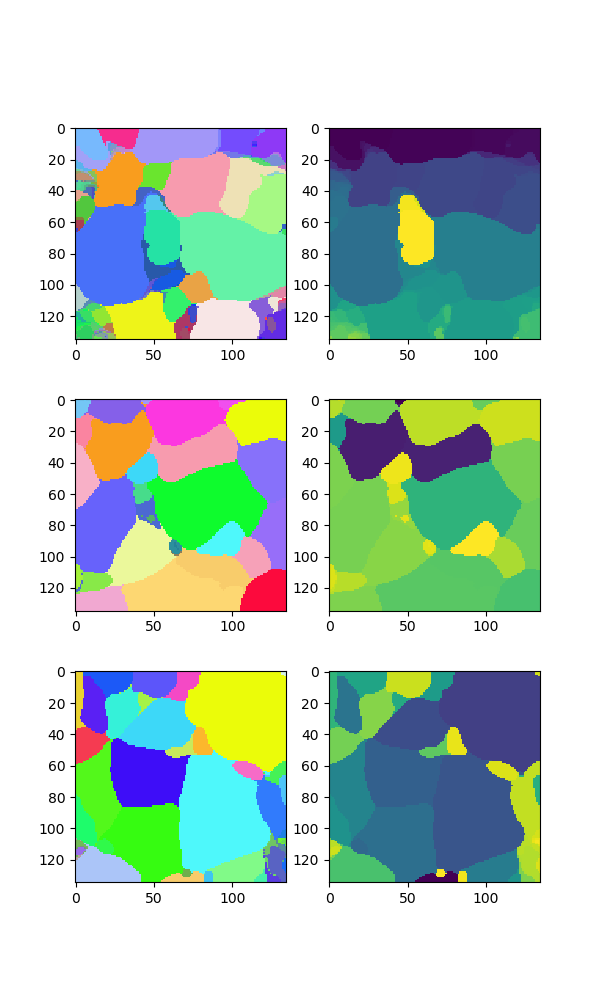

In [28]:
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(6, 10))
ax[0,0].imshow(DCT_avg_colours_med[2,:,:])
ax[1,0].imshow(DCT_avg_colours_med[40,:,:])
ax[2,0].imshow(DCT_avg_colours_med[80,:,:])
ax[0,1].imshow(DCT_grains_med[2,:,:])
ax[1,1].imshow(DCT_grains_med[40,:,:])
ax[2,1].imshow(DCT_grains_med[80,:,:])
plt.show()

In [29]:
flattened_imgs = DCT_avg_colours_med.reshape((-1,3))
colours = np.unique(flattened_imgs, axis=0)

In [30]:
len(colours)

646

In [31]:
#Function that creates a greyscale image of lookup values for all unique colours in image stack
def indexing_func(key_list, value_list):
    key_map = {tuple(key): i for i, key in enumerate(key_list)}
    result = np.array([key_map[tuple(value)] for value in value_list])
    return result

In [32]:
indexed_imgs = indexing_func(colours, flattened_imgs)

In [33]:
indexed_imgs = indexed_imgs.reshape((DCT_colours.shape[0:3]))
indexed_imgs.shape

(116, 135, 135)

<IPython.core.display.Javascript object>


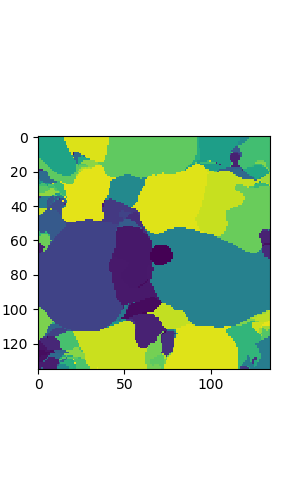

In [34]:
fig, ax = plt.subplots(figsize=(3, 5))
ax.imshow(indexed_imgs[0])
plt.show()

<IPython.core.display.Javascript object>


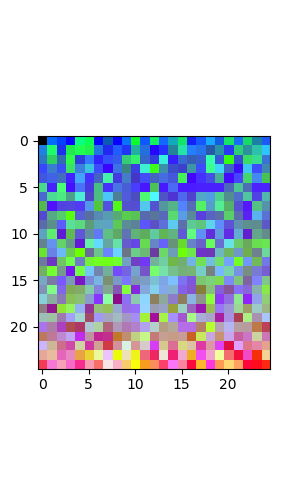

In [62]:
fig, ax = plt.subplots(figsize=(3, 5))
factor = len(colours) - int(np.sqrt(len(colours)))*int(np.sqrt(len(colours)))
step = 1
plt.imshow(colours[:-factor:step].reshape((int(np.sqrt(len((colours)-factor)/step)),int(np.sqrt(len((colours)-factor)/step)),-1)))
plt.show()

In [35]:
cwd = os.getcwd()
for i in range(len(indexed_imgs)):
    imageio.imwrite(os.path.join(cwd,'Indexed','indexed'+str(i)+'.tif'), indexed_imgs[i,:,:].astype(np.uint16))
np.save(os.path.join(cwd,'colours.npy'), colours)

In [36]:
DCT_rodrigues = DCT_data['Rodrigues'][()]

In [41]:
DCT_avg_rod_med = np.zeros_like(DCT_rodrigues)
for grain_id in range(DCT_grains_med.max()+1):
    grain = get_grain_location(DCT_grains_med, grain_id)
    avg_rod = DCT_rodrigues[tuple(grain)].mean(axis=0)
    DCT_avg_rod_med[tuple(grain)] = avg_rod

C:\Users\ZEISS\Miniconda3\envs\ColorIndex\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\Users\ZEISS\Miniconda3\envs\ColorIndex\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


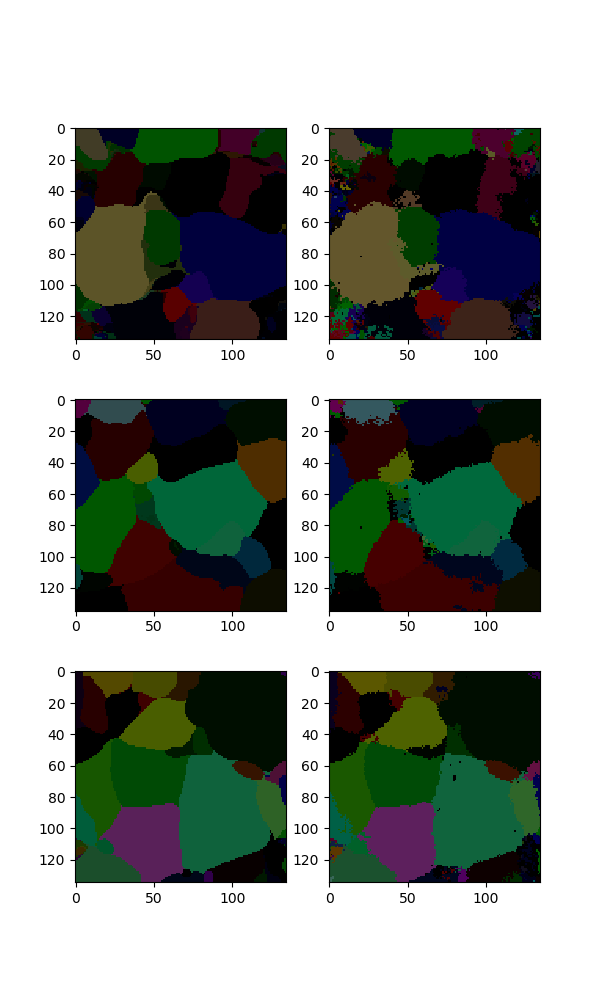

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [42]:
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(6, 10))
ax[0,0].imshow(DCT_avg_rod_med[2,:,:])
ax[1,0].imshow(DCT_avg_rod_med[40,:,:])
ax[2,0].imshow(DCT_avg_rod_med[80,:,:])
ax[0,1].imshow(DCT_rodrigues[2,:,:])
ax[1,1].imshow(DCT_rodrigues[40,:,:])
ax[2,1].imshow(DCT_rodrigues[80,:,:])
plt.show()

In [40]:
print(DCT_rodrigues.max())
print(DCT_rodrigues.min())
print(DCT_rodrigues.shape)

0.41411418
-0.41417694
(116, 135, 135, 3)


In [43]:
f.close()

In [44]:
file_name = r'C:\Users\U3RWHITE\Documents\GitHub\PythonDataProcessing\ColourIndexing\h5LSU\LSU_DCT.h5'
f1 = h5py.File(file_name, 'r+')     # open the file
data = f1['LabDCT/Data/Rodrigues']       # load the data
data[...] = DCT_avg_rod_med                  # assign new values to data
f1.close()

<IPython.core.display.Javascript object>


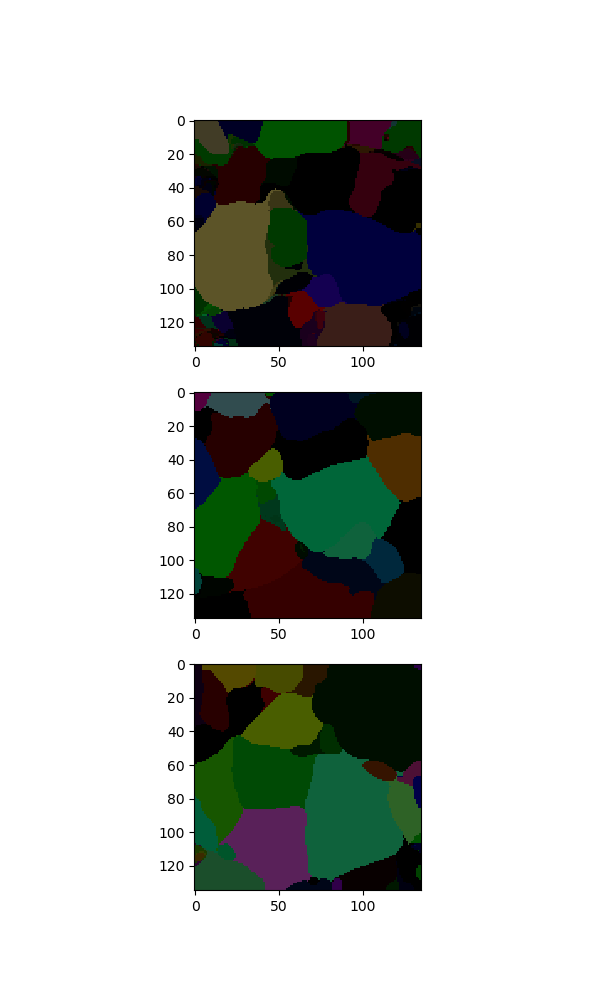

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [51]:
f1 = h5py.File(file_name)
data = f1['LabDCT/Data/Rodrigues'][()]
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(6, 10))
ax[0].imshow(data[2,:,:])
ax[1].imshow(data[40,:,:])
ax[2].imshow(data[80,:,:])
plt.show()

In [53]:
file_name = r'C:\Users\U3RWHITE\Documents\GitHub\PythonDataProcessing\ColourIndexing\h5LSU\LSU_DCT.h5'
f1 = h5py.File(file_name, 'r+')     # open the file
data = f1['LabDCT/Data/GrainId']       # load the data
data[...] = DCT_grains_med                  # assign new values to data
f1.close()

<IPython.core.display.Javascript object>


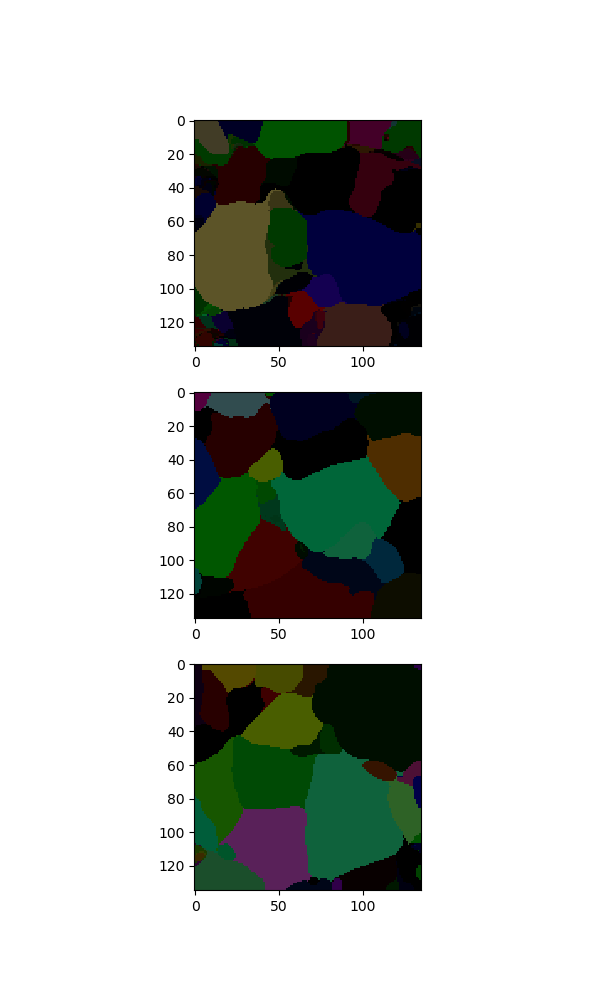

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [54]:
f1 = h5py.File(file_name)
data = f1['LabDCT/Data/Rodrigues'][()]
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(6, 10))
ax[0].imshow(data[2,:,:])
ax[1].imshow(data[40,:,:])
ax[2].imshow(data[80,:,:])
plt.show()

<IPython.core.display.Javascript object>


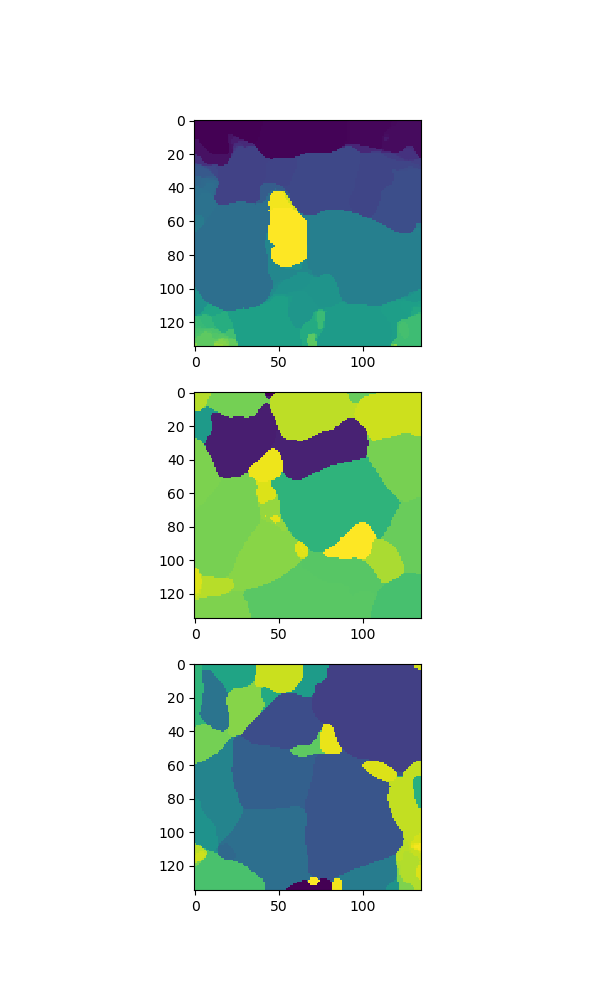

In [55]:
f1 = h5py.File(file_name)
data = f1['LabDCT/Data/GrainId'][()]
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(6, 10))
ax[0].imshow(data[2,:,:])
ax[1].imshow(data[40,:,:])
ax[2].imshow(data[80,:,:])
plt.show()